# Connecting to PySpark with MongoDB and Loading Data

Install MongoDB and import necessary libraries

In [1]:
pip install "pymongo[srv]" 

In [2]:
import pymongo
import json
from pymongo import MongoClient, InsertOne

Set up MongoDB connection

In [3]:
## DO NOT RUN AGAIN
# client = pymongo.MongoClient("mongodb+srv://rainaB:?@cluster-bdat.axukv4y.mongodb.net/?retryWrites=true&w=majority")
# db = client.BDAT1008
# collection = db.headline

Import data to MongoDB Atlas

In [4]:
## import data to mongoDB
## DO NOT RUN AGAIN
# requesting = []
# 
# with open(r"Sarcasm_Headlines_Dataset.json") as f:
#     for jsonObj in f:
#         myDict = json.loads(jsonObj)
#         requesting.append(InsertOne(myDict))
# 
# result = collection.bulk_write(requesting)

Install and setup PySpark

In [5]:
!pip install -q pyspark #install the pyspark package

     |████████████████████████████████| 281.4 MB 25 kB/s 
     |████████████████████████████████| 199 kB 58.3 MB/s 


In [6]:
!curl -O https://repo1.maven.org/maven2/org/mongodb/spark/mongo-spark-connector_2.12/3.0.1/mongo-spark-connector_2.12-3.0.1.jar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  539k  100  539k    0     0  2630k      0 --:--:-- --:--:-- --:--:-- 2737k


Import SparkSession and connect to MongoDB Database

In [7]:
from pyspark.sql import SparkSession

uri = "mongodb+srv://rainaB:?@cluster-bdat.axukv4y.mongodb.net/?retryWrites=true&w=majority"

spark = SparkSession \
    .builder \
    .appName("BDAT1008") \
    .config("spark.mongodb.read.connection.uri", uri) \
    .config("spark.mongodb.write.connection.uri", uri) \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.12:3.0.1')\
    .getOrCreate()

spark

Read the Headline-Sarcasm data from MongoDB

In [8]:
df = spark.read\
    .format("com.mongodb.spark.sql.DefaultSource")\
    .option("uri", uri)\
    .option("database","BDAT1008")\
    .option("collection", "headline")\
    .load()
  
df.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- article_link: string (nullable = true)
 |-- headline: string (nullable = true)
 |-- is_sarcastic: integer (nullable = true)



In [9]:
df.show(10)

+--------------------+--------------------+--------------------+------------+
|                 _id|        article_link|            headline|is_sarcastic|
+--------------------+--------------------+--------------------+------------+
|{638ebc49aac82155...|https://www.huffi...|former versace st...|           0|
|{638ebc49aac82155...|https://www.huffi...|the 'roseanne' re...|           0|
|{638ebc49aac82155...|https://local.the...|mom starting to f...|           1|
|{638ebc49aac82155...|https://politics....|boehner just want...|           1|
|{638ebc49aac82155...|https://www.huffi...|j.k. rowling wish...|           0|
|{638ebc49aac82155...|https://www.huffi...|advancing the wor...|           0|
|{638ebc49aac82155...|https://www.huffi...|the fascinating c...|           0|
|{638ebc49aac82155...|https://www.huffi...|this ceo will sen...|           0|
|{638ebc49aac82155...|https://politics....|top snake handler...|           1|
|{638ebc49aac82155...|https://www.huffi...|friday's morning ...|

Drop useless columns

In [10]:
# drop useless columns
df = df.drop("article_link","_id")

In [11]:
df.show(10)

+--------------------+------------+
|            headline|is_sarcastic|
+--------------------+------------+
|former versace st...|           0|
|the 'roseanne' re...|           0|
|mom starting to f...|           1|
|boehner just want...|           1|
|j.k. rowling wish...|           0|
|advancing the wor...|           0|
|the fascinating c...|           0|
|this ceo will sen...|           0|
|top snake handler...|           1|
|friday's morning ...|           0|
+--------------------+------------+
only showing top 10 rows



Check null for columns to be used

In [12]:
from pyspark.sql.functions import *
# check null
df_Columns = df.columns
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_Columns]
   ).show()

+--------+------------+
|headline|is_sarcastic|
+--------+------------+
|       0|           0|
+--------+------------+



# Data visualization and Pre-processing

In [13]:
import pyspark.pandas as ps

In [14]:
psdf = df.pandas_api()

In [15]:
psdf.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [16]:
df.groupBy('is_sarcastic').count().show()

+------------+-----+
|is_sarcastic|count|
+------------+-----+
|           1|11724|
|           0|14985|
+------------+-----+



In [17]:
psdf.is_sarcastic.count()

26709

In [18]:
# bins: how many sequence/integer we have
psdf.is_sarcastic.plot.hist(bins=2, title="Number of Sarcastic/not Sarcastic")

Handling punctuations and stopwords

In [19]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import regexp_replace

In [20]:
df_no_punc = df.withColumn("no_punctuation", regexp_replace(
  "headline",
  r"""[!\"#$%&'()*+,\-.\/:;<=>?@\[\\\]^_`{|}~]""",
  " "
))

In [21]:
df_no_punc = df_no_punc.withColumn("no_punctuation", regexp_replace(
  "no_punctuation",
  r"  ",
  " "
))

In [22]:
df_no_punc.show(10)

+--------------------+------------+--------------------+
|            headline|is_sarcastic|      no_punctuation|
+--------------------+------------+--------------------+
|former versace st...|           0|former versace st...|
|the 'roseanne' re...|           0|the roseanne revi...|
|mom starting to f...|           1|mom starting to f...|
|boehner just want...|           1|boehner just want...|
|j.k. rowling wish...|           0|j k rowling wishe...|
|advancing the wor...|           0|advancing the wor...|
|the fascinating c...|           0|the fascinating c...|
|this ceo will sen...|           0|this ceo will sen...|
|top snake handler...|           1|top snake handler...|
|friday's morning ...|           0|friday s morning ...|
+--------------------+------------+--------------------+
only showing top 10 rows



In [23]:
pip install spark-nlp==4.2.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 448 kB 8.0 MB/s 


In [24]:
from nltk.corpus import stopwords
import sparknlp
import nltk
from pyspark.ml.feature import StopWordsRemover, Tokenizer
import string as st

In [25]:
tokenizer = Tokenizer(inputCol="no_punctuation", outputCol="vector")
vector_df = tokenizer.transform(df_no_punc).select("vector", "is_sarcastic")

In [26]:
vector_df.printSchema()
vector_df.show(10)

root
 |-- vector: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- is_sarcastic: integer (nullable = true)

+--------------------+------------+
|              vector|is_sarcastic|
+--------------------+------------+
|[former, versace,...|           0|
|[the, roseanne, r...|           0|
|[mom, starting, t...|           1|
|[boehner, just, w...|           1|
|[j, k, rowling, w...|           0|
|[advancing, the, ...|           0|
|[the, fascinating...|           0|
|[this, ceo, will,...|           0|
|[top, snake, hand...|           1|
|[friday, s, morni...|           0|
+--------------------+------------+
only showing top 10 rows



In [27]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [28]:
# sparknlp.start()

In [29]:
stop = StopWordsRemover().getStopWords()

In [30]:
stop = stop+(stopwords.words('english'))

In [31]:
stop[-10:]

['shouldn',
 "shouldn't",
 'wasn',
 "wasn't",
 'weren',
 "weren't",
 'won',
 "won't",
 'wouldn',
 "wouldn't"]

In [32]:
stop_remover = StopWordsRemover(stopWords=stop)

In [33]:
stop_remover.setInputCol("vector")
stop_remover.setOutputCol("vector_no_stw")

StopWordsRemover_ebe50ddb56d8

In [34]:
vector_no_stopw_df = stop_remover.transform(vector_df).select("vector_no_stw", "is_sarcastic")

In [35]:
vector_no_stopw_df.show(10)

+--------------------+------------+
|       vector_no_stw|is_sarcastic|
+--------------------+------------+
|[former, versace,...|           0|
|[roseanne, reviva...|           0|
|[mom, starting, f...|           1|
|[boehner, wants, ...|           1|
|[j, k, rowling, w...|           0|
|[advancing, world...|           0|
|[fascinating, cas...|           0|
|[ceo, send, kids,...|           0|
|[top, snake, hand...|           1|
|[friday, morning,...|           0|
+--------------------+------------+
only showing top 10 rows



Wordcloud for Text (Not Sarcastic)

(-0.5, 399.5, 199.5, -0.5)

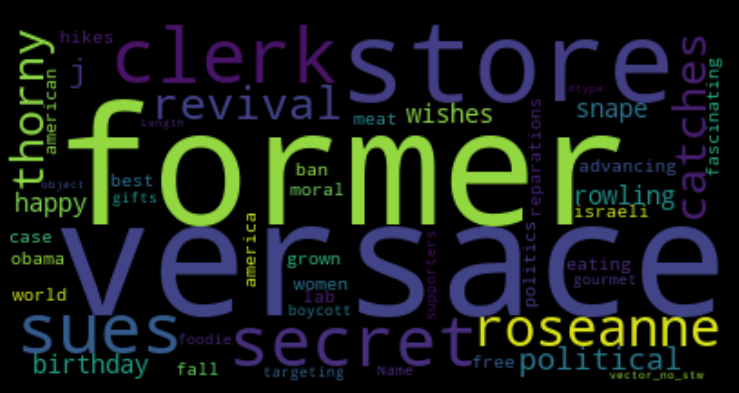

In [36]:
# Plot the WordCloud
# Transfer to pandas
# use wordclound to plot, and check which words is most show in the sentence
from wordcloud import WordCloud
import matplotlib.pyplot as plt
no_stpw_pd_0 = vector_no_stopw_df.toPandas()[vector_no_stopw_df.toPandas()['is_sarcastic']==0]
WC_0 = WordCloud(background_color="black", max_words=500).generate(str(no_stpw_pd_0.vector_no_stw))
fig, ax = plt.subplots(figsize=(13, 7))
fig.patch.set_facecolor('black')
ax.set_facecolor('black')
plt.imshow(WC_0, interpolation='bilinear')
plt.title("Not Sarcast")
plt.axis("off")

Wordcloud for Text (Not Sarcastic)

(-0.5, 399.5, 199.5, -0.5)

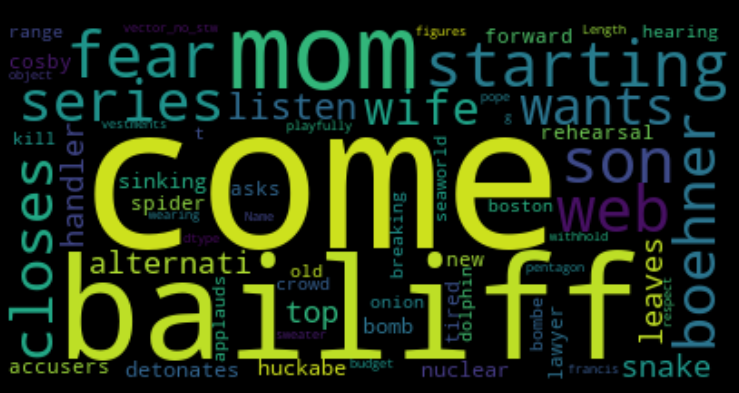

In [37]:
no_stpw_pd_1 = vector_no_stopw_df.toPandas()[vector_no_stopw_df.toPandas()['is_sarcastic']==1]
WC_1 = WordCloud(background_color="black", max_words=500).generate(str(no_stpw_pd_1.vector_no_stw))

fig, ax = plt.subplots(figsize=(13, 7))
fig.patch.set_facecolor('black')
ax.set_facecolor('black')
plt.imshow(WC_1, interpolation='bilinear')
plt.title("Sarcast")
plt.axis("off")

Number of characters in the text

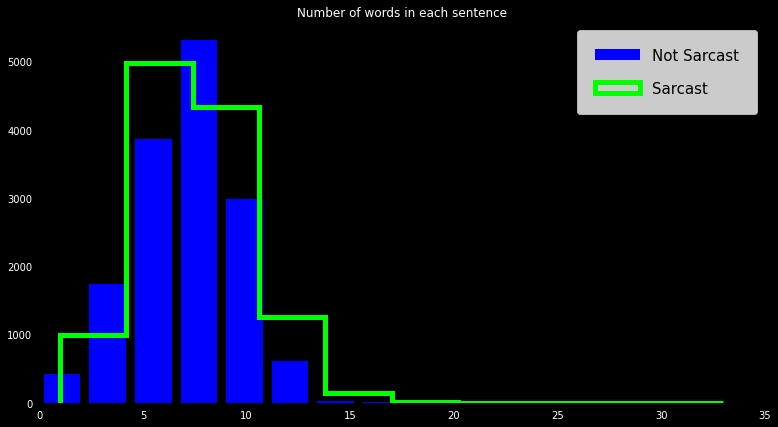

In [38]:
text_len_0 = no_stpw_pd_0.vector_no_stw.str.len()
text_len_1 = no_stpw_pd_1.vector_no_stw.str.len()
fig, ax = plt.subplots(figsize=(13, 7))
fig.patch.set_facecolor('black')
ax.set_facecolor('black')
ax.tick_params(labelcolor='white')
hist_0 = plt.hist(text_len_0, color = 'blue', 
                  histtype ='barstacked', rwidth=0.8, label='Not Sarcast')
hist_1 = plt.hist(text_len_1, color = 'lime', 
                  histtype ='step', rwidth=0.8, linewidth=5, label='Sarcast')
plt.xlim((0, 35))
plt.legend(handlelength=3, borderpad=1.2, labelspacing=1.2, fontsize=15)
plt.title("Number of words in each sentence", color='white')
plt.show()

In [39]:
no_stpw_pd_0.vector_no_stw[0]

['former',
 'versace',
 'store',
 'clerk',
 'sues',
 'secret',
 'black',
 'code',
 'minority',
 'shoppers']

Split data(Training/Testing)

In [40]:
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

# label index
label_stringIdx = StringIndexer(inputCol = "is_sarcastic", outputCol = "label")



Method 1: TFidf

In [41]:
# Tfidf
hashingTF = HashingTF(inputCol="vector_no_stw", outputCol="features")
idf = IDF(inputCol="features", outputCol="idf_features")

### Pipeline Architecture
pipeline = Pipeline(stages=[hashingTF, idf, label_stringIdx])
# Training model, Fit the pipeline to training data.
pipelineFit = pipeline.fit(vector_no_stopw_df)
dataset = pipelineFit.transform(vector_no_stopw_df)
dataset.show(5)

+--------------------+------------+--------------------+--------------------+-----+
|       vector_no_stw|is_sarcastic|            features|        idf_features|label|
+--------------------+------------+--------------------+--------------------+-----+
|[former, versace,...|           0|(262144,[62400,93...|(262144,[62400,93...|  0.0|
|[roseanne, reviva...|           0|(262144,[27846,46...|(262144,[27846,46...|  0.0|
|[mom, starting, f...|           1|(262144,[14072,19...|(262144,[14072,19...|  1.0|
|[boehner, wants, ...|           1|(262144,[28662,30...|(262144,[28662,30...|  1.0|
|[j, k, rowling, w...|           0|(262144,[27028,51...|(262144,[27028,51...|  0.0|
+--------------------+------------+--------------------+--------------------+-----+
only showing top 5 rows



objectiveHistory:


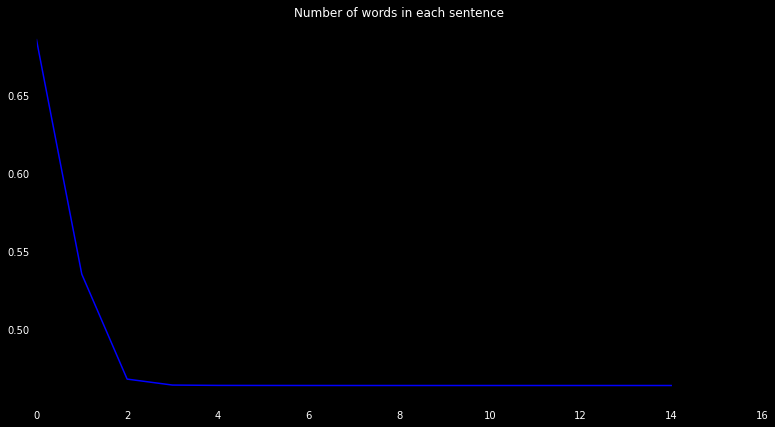

In [42]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# split data for training and test
x_train, x_test = dataset.randomSplit([0.8, 0.2])

# training the model by Logistic regression algorithm 
LR = LogisticRegression(maxIter=20, regParam=0.5)
LR_model = LR.fit(x_train)

# print the change of coefficients history 
LR_model_summary = LR_model.summary
objectiveHistory = LR_model_summary.objectiveHistory
print("objectiveHistory:")

#for objective in objectiveHistory:
#    print(objective)

fig, ax = plt.subplots(figsize=(13, 7))
fig.patch.set_facecolor('black')
ax.set_facecolor('black')
ax.tick_params(labelcolor='white')

plt.plot(objectiveHistory, color = 'b')
plt.xlim((0, 16))
# plt.legend(handlelength=3, borderpad=1.2, labelspacing=1.2, fontsize=15)
plt.title("Number of words in each sentence", color='white')
plt.show()

Test area under ROC Curve: 0.8742862939413715


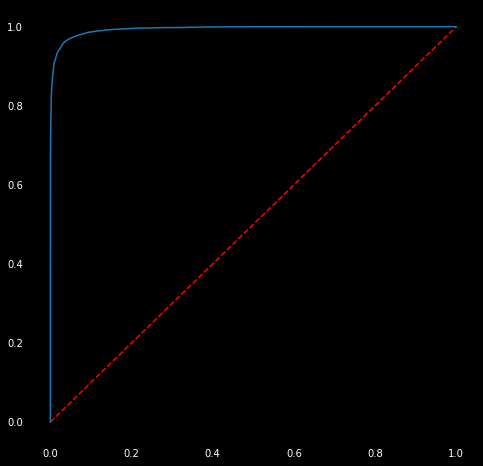

Accuracy of Logistic Regression for embedding(TFidf):  0.7907583379914291


In [43]:
predictions = LR_model.transform(x_test)
evaluator = BinaryClassificationEvaluator()
# print("Coefficients: " + str(LR_model.coefficients))
# print("Intercept: " + str(LR_model.intercept))

# ROC is the probability curve and AUC represents the degree or measure of separability. 
# ROC indicates how much the model is able to distinguish between classes. 
# Higher the AUC, the better the discriminative ability of the model
print("Test area under ROC Curve: "+ str(evaluator.evaluate(predictions)))
fig, ax = plt.subplots(figsize=(8, 8))
fig.patch.set_facecolor('black')
ax.set_facecolor('black')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(labelcolor='white')
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(LR_model.summary.roc.select('FPR').collect(),
         LR_model.summary.roc.select('TPR').collect())
# plt.xlabel('FPR')
# plt.ylabel('TPR')
plt.show()

accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy of Logistic Regression for embedding(TFidf): ",accuracy)

Method 2: Bag of words count

In [44]:
# bag of words count
countVectors = CountVectorizer(inputCol="vector_no_stw", outputCol="features", vocabSize=10000, minDF=5)
pipeline2 = Pipeline(stages=[countVectors, label_stringIdx])

# Fit the pipeline to training documents.
pipelineFit2 = pipeline2.fit(vector_no_stopw_df)
dataset2 = pipelineFit2.transform(vector_no_stopw_df)
dataset2.show(5)

+--------------------+------------+--------------------+-----+
|       vector_no_stw|is_sarcastic|            features|label|
+--------------------+------------+--------------------+-----+
|[former, versace,...|           0|(6699,[34,216,275...|  0.0|
|[roseanne, reviva...|           0|(6699,[162,305,90...|  0.0|
|[mom, starting, f...|           1|(6699,[55,126,142...|  1.0|
|[boehner, wants, ...|           1|(6699,[137,221,25...|  1.0|
|[j, k, rowling, w...|           0|(6699,[33,466,467...|  0.0|
+--------------------+------------+--------------------+-----+
only showing top 5 rows



objectiveHistory:


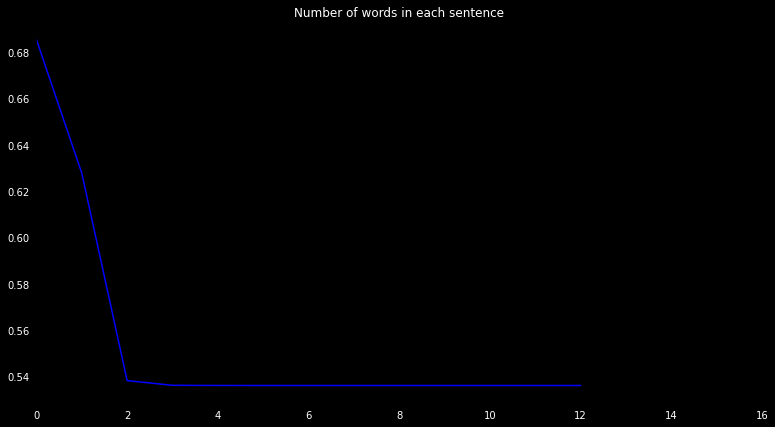

In [45]:
# split data for training and test
x_train2, x_test2 = dataset2.randomSplit([0.8, 0.2])

# training the model by Logistic regression algorithm 
LR2 = LogisticRegression(maxIter=20, regParam=0.5)
LR_CV_model = LR2.fit(x_train2)
# print("Coefficients: " + str(LR_CV_model.coefficients))
# print("Intercept: " + str(LR_CV_model.intercept))

# print the change of coefficients history 
LR_CV_model_summary = LR_CV_model.summary
objectiveHistory2 = LR_CV_model_summary.objectiveHistory
print("objectiveHistory:")
# for objective in objectiveHistory2:
#     print(objective)
fig, ax = plt.subplots(figsize=(13, 7))
fig.patch.set_facecolor('black')
ax.set_facecolor('black')
ax.tick_params(labelcolor='white')

plt.plot(objectiveHistory2, color = 'b')
plt.xlim((0, 16))
plt.title("Number of words in each sentence", color='white')
plt.show()

Test area under ROC: 0.8832961382404126


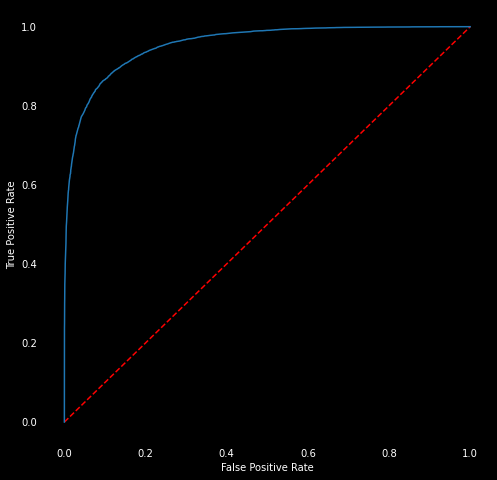

Accuracy :  0.7939914163090128


In [46]:
predictions_CV = LR_CV_model.transform(x_test2)
evaluator_CV = BinaryClassificationEvaluator()

# ROC is the probability curve and AUC represents the degree or measure of separability. 
# ROC indicates how much the model is able to distinguish between classes. 
# Higher the AUC, the better the discriminative ability of the model
print("Test area under ROC: "+ str(evaluator_CV.evaluate(predictions_CV)))
fig, ax = plt.subplots(figsize=(8, 8))
fig.patch.set_facecolor('black')
ax.set_facecolor('black')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(labelcolor='white')
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(LR_CV_model.summary.roc.select('FPR').collect(),
         LR_CV_model.summary.roc.select('TPR').collect())
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


accuracy_CV = predictions_CV.filter(predictions_CV.label == predictions_CV.prediction).count() / float(predictions_CV.count())
print("Accuracy : ",accuracy_CV)

